# Main notebook to process indexed datasets into summaries.

## Generate sentence pairs

In [3]:
import itertools
import json
import nltk
import pandas as pd

In [99]:
save_dir = input("enter path to base directory to save outputs to:\n")

enter path to base directory to save outputs to:
 ../data/test16


In [101]:
input_path = input("enter path to indexed dataset:\n")  # default encoding is utf-8
with open(input_path) as f:
    sents_df = pd.read_csv(f, delimiter=',')
sents_df.head()

enter path to indexed dataset:
 ../data/test11/cheese.csv


,index,sentence
0,0,Arrived quickly and in perfect condition!
1,1,Will definitely look them up when I'm craving ...
2,2,Warning first off: This has cows milk and crea...
3,3,So if you want a pure goat milk cheese visit t...
4,4,I haven't seen it on Amazon.Second: This is DE...


In [102]:
indices = list(sents_df.index)

# generate all pairs in the set of sentences.
indices_list = list(itertools.combinations(indices, 2))
print('no. of sentences: ', len(indices))
print('no. of sentence pairs: ', len(indices_list), '\n')

no. of sentences:  133
no. of sentence pairs:  8778 



In [104]:
# generate all sentence pairs and save into a csv for manual labelling.
data = []
for pair in indices_list:
    data.append([pair[0], pair[1], sents_df.iloc[pair[0]]['sentence'], sents_df.iloc[pair[1]]['sentence']])

df = pd.DataFrame(data=data, columns=['first_index', 'second_index', 'first', 'second'])
display(df)

,first_index,second_index,first,second
0,0,1,Arrived quickly and in perfect condition!,Will definitely look them up when I'm craving ...
1,0,2,Arrived quickly and in perfect condition!,Warning first off: This has cows milk and crea...
2,0,3,Arrived quickly and in perfect condition!,So if you want a pure goat milk cheese visit t...
3,0,4,Arrived quickly and in perfect condition!,I haven't seen it on Amazon.Second: This is DE...
4,0,5,Arrived quickly and in perfect condition!,"It is a unique caramel flavor, and makes a gre..."
...,...,...,...,...
8773,129,131,I had it as a small child in Norway and was th...,THe cheese?
8774,129,132,I had it as a small child in Norway and was th...,It's perfect!
8775,130,131,I ended up buying this item from the Norwegian...,THe cheese?
8776,130,132,I ended up buying this item from the Norwegian...,It's perfect!


In [105]:
is_save = input('save indexed paired dataset? (y/n):\n')
if is_save.lower() == 'y':
    df.to_csv(save_dir + '/' + 'paired_sentences.csv')
else:
    print('not saving indexed paired dataset.')

save indexed paired dataset? (y/n):
 y


## Perform inferences of distances between sentences in a sentence pair

In [9]:
import torch
from fairseq.data.data_utils import collate_tokens
from math import exp
import numpy as np

class RobertaMNLI:
    # todo: create similar wrapper classes for other NLI engines.
    # todo: create a wrapper superclass and subclass from there.
    # roberta code adapted from https://github.com/pytorch/fairseq/tree/master/examples/roberta
    def __init__(self, rel_path):
        """
        :param rel_path: relative path to pytorch hub directory.
        """
        self.output_map = {
            0: 'contradiction',
            1: 'neutral',
            2: 'entailment'
        }
        
        torch.hub.set_dir(rel_path)
        self.roberta = torch.hub.load('pytorch/fairseq', 'roberta.large.mnli')  # works
        self.roberta.cuda()
        self.roberta.eval()
        
    def predict_one(self, S1, S2, return_probs=False):
        batch = collate_tokens(
            [self.roberta.encode(S1, S2)], pad_idx=1
        )
        logprobs = self.roberta.predict('mnli', batch)
        classes_tsr = logprobs.argmax(dim=1)
        classes = classes_tsr.tolist()  
        
        if return_probs == True:
            logprobs_list=[logprob.item() for logprob in logprobs[0]]
            prob_list =  [pow(exp(1), logprob) for logprob in logprobs_list]
            return prob_list
        else:
            return classes[0]  # 0 is contradiction, 1 is neutral, 2 is entailment.

In [10]:
predictor = RobertaMNLI(rel_path="../../roberta/hub")

Using cache found in ../../roberta/hub\pytorch_fairseq_master


In [103]:
from datetime import datetime
print(datetime.now())
results = list()
for i in range(len(df)):
    s1 = df.iloc[i]['first']
    s2 = df.iloc[i]['second']
    CNE1 = predictor.predict_one(s1, s2, return_probs=True)
    CNE2 = predictor.predict_one(s2, s1, return_probs=True)
    row = CNE1+ CNE2
    results.append(row)

scores_df = pd.DataFrame(data=results, columns=['C1', 'N1', 'E1', 'C2', 'N2', 'E2'])
print(datetime.now())

2020-10-28 01:46:35.274413
2020-10-28 01:46:57.858287


In [135]:
# load from previously saved data.
scores_df = pd.read_csv("../data/test11/nliScores.csv")
scores_df = scores_df.drop(columns=["dist", "Unnamed: 0"])
scores_df

,first_index,second_index,first,second,C1,N1,E1,C2,N2,E2
0,0,1,Arrived quickly and in perfect condition!,Will definitely look them up when I'm craving ...,0.003894,0.994330,0.001776,0.692627,0.303062,0.004310
1,0,2,Arrived quickly and in perfect condition!,Warning first off: This has cows milk and crea...,0.389742,0.600257,0.010000,0.608994,0.388454,0.002553
2,0,3,Arrived quickly and in perfect condition!,So if you want a pure goat milk cheese visit t...,0.045605,0.823383,0.131012,0.000958,0.997880,0.001162
3,0,4,Arrived quickly and in perfect condition!,I haven't seen it on Amazon.Second: This is DE...,0.219815,0.766286,0.013899,0.002497,0.996711,0.000791
4,0,5,Arrived quickly and in perfect condition!,"It is a unique caramel flavor, and makes a gre...",0.009245,0.984715,0.006040,0.003260,0.994220,0.002519
...,...,...,...,...,...,...,...,...,...,...
8773,129,131,I had it as a small child in Norway and was th...,THe cheese?,0.391161,0.598706,0.010133,0.009251,0.985563,0.005186
8774,129,132,I had it as a small child in Norway and was th...,It's perfect!,0.003061,0.982946,0.013993,0.000744,0.997642,0.001614
8775,130,131,I ended up buying this item from the Norwegian...,THe cheese?,0.604361,0.378152,0.017486,0.029996,0.967619,0.002385
8776,130,132,I ended up buying this item from the Norwegian...,It's perfect!,0.310162,0.685528,0.004310,0.008300,0.990410,0.001290


In [136]:
def gen_dist2(row, epsilon=0.1):
    '''
    Generate distance score based on Contradiction, Entailment and Neutrality probabilities for both directions.
    Assumes that C+E+N=1.
    :param row: an axis of a Pandas.DataFrame.
    :param epsilon: the max difference between C and E such that below this value, we regard C,E,N as neutral.
    '''    
    CEN1 = [row['C1'], row['E1'], row['N1']]
    CEN2 = [row['C2'], row['E2'], row['N2']]
    
    # Select the directionality of the statement pair and take that direction as representative 
    # of the "undirected" pair's relation.
    # Previously, 
    # An alternative to the following code block is to regard the longer statement as the 
    # premise, which is some existing papers' default approach. 
    arg1 = np.argmax(CEN1)
    arg2 = np.argmax(CEN2)
    if arg1 == arg2:
        if CEN1[arg1] > CEN2[arg2]:
            CEN = CEN1
        else:
            CEN = CEN2
    elif arg1 == 0:
        # e.g. arg1 == 0 and arg2 == 1
        # e.g. arg1 == 0 and arg2 == 2
        # i.e. priortise C
        CEN = CEN1
    elif arg2 == 0:
        # e.g. arg2 == 0 and arg1 == 2
        # i.e. priortise C
        CEN = CEN2
    elif arg1 == 1:
        # i.e. prioritise E
        CEN = CEN1
    elif arg2 == 1:
        # i.e. prioritise E
        CEN = CEN2
    else:
        raise Error("bug?")
    
    # return the distance
    C, E, N = CEN[0], CEN[1], CEN[2]
    argmax = np.argmax(CEN)
    if argmax == 2:
        return 0.5
    if abs(C - E) < epsilon:
        return 0.5
    if C - E >= epsilon:
        return C/(C+E)
    if E - C >= epsilon:
        return 1 - E/(C+E)

In [137]:
dist_ser = scores_df.apply(lambda row: gen_dist2(row), axis=1)
dist_ser.name = 'dist'
scores_df = scores_df.join(dist_ser)
#scores_df = df.join(scores_df)  # uncomment when not generating dists from prev generated NLI values. 
scores_df.to_csv(save_dir + '/' + 'nliScores.csv')

In [138]:
nans = np.isnan(scores_df.dist.values)
np.unique(nans, return_counts=True)

(array([False]), array([8778], dtype=int64))

In [ ]:
scores_df

## Clustering based on precomputed pairwise distances.

In [168]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=3)
# import scipy
# from scipy.cluster.hierarchy import dendrogram,linkage
# from scipy.cluster.hierarchy import fcluster
# from scipy.cluster.hierarchy import cophenet
# from scipy.spatial.distance import pdist

import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sb

In [139]:
sents_df = pd.read_csv("../data/test11/cheese.csv", delimiter=',')
# sents_df = pd.read_csv("../data/test13/cheese_small2.csv", delimiter=',')
scores_df = pd.read_csv("../data/test16/nliScores.csv", delimiter=',')

In [140]:
# convert pairwise distances to a distance matrix.
# we utilise a pivot table to do this

# first, redundant pairs, e.g. (sentence_1,sentence_1) are missing.
# add the redundant pairs to the df.
# we need this for the pivot function to generate the correct indices and columns.
first = np.unique(scores_df['first_index'].values)
second = np.unique(scores_df['second_index'].values)
combined_arr = np.concatenate((first, second))
sentences = np.unique(combined_arr)
add_data = np.column_stack([sentences, sentences, np.zeros(len(sentences))])
add_data = add_data.astype(np.int)

add_df = pd.DataFrame(data=add_data, columns=['first_index','second_index','dist'])
scores_df = scores_df.append(add_df, ignore_index=True)
df_piv = scores_df.pivot("first_index", "second_index", "dist").fillna(0)
piv_arr = df_piv.values
dist_mat = piv_arr + np.transpose(piv_arr)

In [141]:
# generate pairwise matrix for saving.
intersentence = pd.DataFrame(data=dist_mat, index=df_piv.index, columns=df_piv.columns)
path = save_dir + '/' + 'pairwiseMatrix.csv'
intersentence.to_csv(path)

In [143]:
# LOAD pairwise matrix

# load intersentence pairwise distance matrix.
df_piv = pd.read_csv("../data/test16/pairwiseMatrix.csv")
print("loaded data from disk.")
display(df_piv.head())
df_piv = df_piv.drop(columns=['first_index'])
display(df_piv.head())
dist_mat = df_piv.values

loaded data from disk.


,first_index,0,1,2,3,4,5,6,7,8,...,123,124,125,126,127,128,129,130,131,132
0,0,0.000000,0.993815,0.995826,0.500000,0.5,0.5,0.5,0.500000,0.990624,...,0.500000,0.5,0.5,0.500000,0.5,0.5,0.500000,0.5,0.986710,0.001253
1,1,0.993815,0.000000,0.500000,0.500000,0.5,0.5,0.5,0.500000,0.500000,...,0.500000,0.5,0.5,0.500000,0.5,0.5,0.500000,0.5,0.600821,0.969384
2,2,0.995826,0.500000,0.000000,0.994954,0.5,0.5,0.5,0.500000,0.993600,...,0.500000,0.5,0.5,0.500000,0.5,0.5,0.500000,0.5,0.923128,0.999597
3,3,0.500000,0.500000,0.994954,0.000000,0.5,0.5,0.5,0.500000,0.500000,...,0.500000,0.5,0.5,0.500000,0.5,0.5,0.500000,0.5,0.740142,0.500000
4,4,0.500000,0.500000,0.500000,0.500000,0.0,0.5,0.5,0.977548,0.500000,...,0.995982,0.5,0.5,0.987385,0.5,0.5,0.996607,0.5,0.500000,0.500000


,0,1,2,3,4,5,6,7,8,9,...,123,124,125,126,127,128,129,130,131,132
0,0.000000,0.993815,0.995826,0.500000,0.5,0.5,0.5,0.500000,0.990624,0.500000,...,0.500000,0.5,0.5,0.500000,0.5,0.5,0.500000,0.5,0.986710,0.001253
1,0.993815,0.000000,0.500000,0.500000,0.5,0.5,0.5,0.500000,0.500000,0.994379,...,0.500000,0.5,0.5,0.500000,0.5,0.5,0.500000,0.5,0.600821,0.969384
2,0.995826,0.500000,0.000000,0.994954,0.5,0.5,0.5,0.500000,0.993600,0.500000,...,0.500000,0.5,0.5,0.500000,0.5,0.5,0.500000,0.5,0.923128,0.999597
3,0.500000,0.500000,0.994954,0.000000,0.5,0.5,0.5,0.500000,0.500000,0.500000,...,0.500000,0.5,0.5,0.500000,0.5,0.5,0.500000,0.5,0.740142,0.500000
4,0.500000,0.500000,0.500000,0.500000,0.0,0.5,0.5,0.977548,0.500000,0.987318,...,0.995982,0.5,0.5,0.987385,0.5,0.5,0.996607,0.5,0.500000,0.500000


In [144]:
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score
condensed_mat = squareform(dist_mat)
linkage = 'complete'

clusters = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage=linkage, distance_threshold=0.49)
clusters.fit_predict(dist_mat)

# use metric to measure/compare goodness of clusters based on internal coherence and 
# external coupling. we can consider maximising the Dunn index.
# or consider average sillhouette width (maximise), which is available in sklearn.
silhouette_avg = silhouette_score(dist_mat, clusters.labels_, metric='precomputed')
print(clusters.n_clusters_, ": ", silhouette_avg)

105 :  0.30171710286381026


In [69]:
# sil_scores_arr = np.asarray(sil_scores)
# print('max avg silhouette score: ', sil_scores_arr.max())
# OPTIMAL_K = np.where(sil_scores_arr == sil_scores_arr.max())[0][0] + 2
# print('nclusters w max avg silhouette score: ', OPTIMAL_K)

In [146]:
for i in range(clusters.n_clusters_):
    indices = np.where(clusters.labels_ == i)[0]
    
    print(f'cluster {i} (size {len(indices)}):')
    print(indices)
    for idx in indices:
        display(sents_df.iloc[idx]['sentence'])
    print('\n')

cluster 0 (size 2):
[56 78]


cluster 1 (size 2):
[ 3 43]


cluster 2 (size 2):
[106 131]


cluster 3 (size 2):
[105 118]


cluster 4 (size 2):
[50 51]


cluster 5 (size 2):
[111 128]


cluster 6 (size 2):
[ 53 117]


cluster 7 (size 3):
[ 83  97 109]


cluster 8 (size 2):
[14 20]


cluster 9 (size 2):
[ 4 18]


cluster 10 (size 2):
[87 92]


cluster 11 (size 2):
[ 6 37]


cluster 12 (size 2):
[ 35 132]


cluster 13 (size 1):
[130]


cluster 14 (size 1):
[115]


cluster 15 (size 1):
[116]


cluster 16 (size 1):
[129]


cluster 17 (size 2):
[44 47]


cluster 18 (size 2):
[77 98]


cluster 19 (size 3):
[ 0 10 55]


cluster 20 (size 1):
[126]


cluster 21 (size 1):
[120]


cluster 22 (size 2):
[38 88]


cluster 23 (size 2):
[ 31 123]


cluster 24 (size 1):
[112]


cluster 25 (size 1):
[124]


cluster 26 (size 4):
[  5   7  19 107]


cluster 27 (size 1):
[127]


cluster 28 (size 1):
[74]


cluster 29 (size 1):
[73]


cluster 30 (size 1):
[104]


cluster 31 (size 1):
[90]


cluster 32 (size

In [147]:
import json
# save clusters into JSON dict
clusters_dict = dict()
for i in range(clusters.n_clusters_):
    indices = np.where(clusters.labels_ == i)[0]
    sents = list()
    for idx in indices:
        sents.append(int(df_piv.index[idx]))
    clusters_dict[i] = sents

path = save_dir + '/' + 'clusters.json'
with open(path, 'w') as fp:
    json.dump(clusters_dict, fp)

In [290]:
# DEPRECATED
# Compute the distance of one cluster to another cluster using average pairwise distance
# between two elements (one in each cluster).  
# print('------')
# print(f'\nno. of clusters = {n_clusters}')
# # find average distances between clusters and output a new distance matrix
# labels = [i for i in range(clusters.n_clusters_)]
# avg_dist_arr = np.zeros(shape=(clusters.n_clusters_, clusters.n_clusters_))
# for i in range(clusters.n_clusters_):
#     indices = np.where(clusters.labels_ == i)[0]
#     labels.remove(i)
#     for j in labels:
#         other_indices = np.where(clusters.labels_ == j)[0]
#         intra_dist_arr = np.zeros(shape=(len(indices), len(other_indices)))

#         for k, index in enumerate(indices):
#             for m, other_index in enumerate(other_indices):
#                 intra_dist_arr[k][m] = dist_mat[index][other_index]

#         #print (f'cluster {i} against cluster {j}:')
#         #print(intra_dist_arr)

#         avg_dist = np.average(intra_dist_arr)
#         #print(avg_dist)
#         avg_dist_arr[i][j] = avg_dist
# print(avg_dist_arr)

## Visualise network of clusters

In [ ]:
import networkx as nx
import string

In [ ]:
G = nx.from_numpy_matrix(tmp)
print(G.nodes())
print(G.edges().data())
#G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())),string.ascii_uppercase)))

import pydot
from networkx.drawing.nx_pydot import write_dot

print("using package pydot")
path = save_dir + '/' + 'clusterViz.dot'
write_dot(G, path)
# you can then use the various graphviz CLI to generate the image. E.g. "neato -Tpng clusterViz.dot -o clusterViz.png"
# see https://www.graphviz.org/pdf/neatoguide.pdf for more info on modifying dot files.
# fdp or sfdp can be used instead of neato. 

## Summarize

In [148]:
import numpy as np

# LOAD DATA

# load indexed sentences:
sents_df = pd.read_csv(f"../data/test11/cheese.csv")
# sents_df = pd.read_csv(f"../data/test7/Trump1.csv")

folder = "test16"
# load intersentence pairwise distance matrix.
df_piv = pd.read_csv(f"../data/{folder}/pairwiseMatrix.csv")
df_piv = df_piv.drop(columns=['first_index'])
dist_mat = df_piv.values

# load clusters.
with open(f"../data/{folder}/clusters.json") as fp:
    tmp = json.load(fp)

clusters_dict = dict()
for str_idx, cluster in tmp.items():
    clusters_dict[int(str_idx)] = cluster
    
print("loaded data from disk.")
display(clusters_dict)

loaded data from disk.


{0: [56, 78],
 1: [3, 43],
 2: [106, 131],
 3: [105, 118],
 4: [50, 51],
 5: [111, 128],
 6: [53, 117],
 7: [83, 97, 109],
 8: [14, 20],
 9: [4, 18],
 10: [87, 92],
 11: [6, 37],
 12: [35, 132],
 13: [130],
 14: [115],
 15: [116],
 16: [129],
 17: [44, 47],
 18: [77, 98],
 19: [0, 10, 55],
 20: [126],
 21: [120],
 22: [38, 88],
 23: [31, 123],
 24: [112],
 25: [124],
 26: [5, 7, 19, 107],
 27: [127],
 28: [74],
 29: [73],
 30: [104],
 31: [90],
 32: [110],
 33: [119],
 34: [101],
 35: [121],
 36: [102],
 37: [96],
 38: [70],
 39: [99],
 40: [122],
 41: [95],
 42: [94],
 43: [32],
 44: [86],
 45: [103, 125],
 46: [11, 24],
 47: [113, 114],
 48: [13, 22],
 49: [89],
 50: [81],
 51: [93],
 52: [80],
 53: [85],
 54: [79],
 55: [46],
 56: [75],
 57: [72],
 58: [41],
 59: [2],
 60: [71],
 61: [61],
 62: [69],
 63: [67],
 64: [66],
 65: [65],
 66: [57],
 67: [63],
 68: [64],
 69: [68],
 70: [62],
 71: [60],
 72: [108],
 73: [52],
 74: [49],
 75: [59],
 76: [54],
 77: [48],
 78: [40],
 79: [42

## Reliability Ranking approach to multi-summarization.

In [149]:
import itertools
def intra_clust_dis_mat(clust, pairwise):
    """
    :param clust: list of sentence indices that form the cluster.
    :param pairwise: numpy.ndarray of pairwise dist matrix of all points. AKA affinity matrix.
    :returns: 
    """
    sorted_clust = sorted(clust)
    pairs = list(itertools.combinations(clust, 2))
    tmp = np.zeros((len(clust), len(clust)))
    for pair in pairs:
        tmp_idx0 = sorted_clust.index(pair[0])
        tmp_idx1 = sorted_clust.index(pair[1])
        tmp[tmp_idx0][tmp_idx1] = pairwise[pair[0], pair[1]]
    intraclust = tmp + np.transpose(tmp)
    return intraclust, sorted_clust


def generate_intraclusts(clusters_dict, pairwise):
    """
    :param clusters_dict: cluster_index: list(indices of sentences in that cluster)}.
    :param pairwise: numpy.ndarray of pairwise dist matrix of all points. AKA affinity matrix.
    :returns: dict {cluster_idx: (asc_sorted_indices, intraclust_dist_mat)}. the ascending sorted indices corresponds/aligns
    to the row or col index of the dist mat.
    """
    clusters_dict2 = dict()
    for i, _  in clusters_dict.items():
        intraclust, sorted_clust = intra_clust_dis_mat(clusters_dict[i], pairwise)
        clusters_dict2[i] = (sorted_clust, intraclust)
    return clusters_dict2


from lexrank.lexrank import degree_centrality_scores
def choose_salient(dis_mat, clust):
    """
    :param dis_mat: disimilarity or distance matrix. every value is between 0-1, inclusive.
    :clust: list of sentence indices corresponding to the row-indexing of dis_mat.
    :returns: sentence index of most salient sentence.
    """
    similarity_matrix = 1 - dis_mat
    #print(similarity_matrix)
    scores = degree_centrality_scores(similarity_matrix, threshold=None)
    #print(scores)
    return clust[np.argmax(scores)]
    
def interclust_dist_mat(clusters, pairwise):
    """
    compute intercluster distances based on the distance between the most salient elements of each cluster.
    :param clusters: dict {cluster_idx: (sent_indices, intraclust_dist_mat)}. indices align to rows of intraclust dist matrix.
    the cluster indices must always start from 0.
    :param pairwise: numpy.ndarray of pairwise dist matrix of all points. AKA affinity matrix.
    :returns: intercluster distance matrix.
    """
    # find salient sentence (index) of each cluster.
    salient_indices = dict()
    for cluster_idx, val in clusters.items():
        indices = val[0]
        intraclust = val[1]
        salient_idx = choose_salient(intraclust, indices)
        salient_indices[cluster_idx] = salient_idx
    
    # generate intercluster dist matrix.
    interclust = np.zeros((len(clusters), len(clusters)))
    for i in range(len(interclust)):
        for j in range(len(interclust)):
            sent_idx1 = salient_indices[i]
            sent_idx2 = salient_indices[j]
            interclust[i][j] = pairwise[sent_idx1][sent_idx2]
    return interclust

In [158]:
def rank_by_reliability(clusters_dict, intercluster, contra_threshold=0.6):
    """
    :param clusters_dict: dict of clusters. {cluster index: list(sentence indices)}.
    :param intercluster: square numpy.ndarray representing distances between each cluster.
    :return scores: list((score, cluster_idx)) 
    """
    scores = list()
    for cluster_idx in range(len(intercluster)):
        contra_size = 0
        for other_cluster_idx in range(len(intercluster)):
            if intercluster[cluster_idx][other_cluster_idx] > contra_threshold:
                contra_size = contra_size + len(clusters_dict[other_cluster_idx])
        numer = 1 + contra_size
        denom = len(clusters_dict[cluster_idx])
        score = numer/denom
        scores.append((score, cluster_idx))
    return sorted(scores, reverse=True)

In [159]:
clusters_dict2 = generate_intraclusts(clusters_dict, dist_mat)  # clusters_dict with intracluster dist matrix.

intercluster_dists = interclust_dist_mat(clusters_dict2, dist_mat)
scores = rank_by_reliability(clusters_dict, intercluster_dists, contra_threshold=0.6)

In [152]:
path = save_dir + '/' + 'clusterDistances.csv'
np.savetxt(path, intercluster_dists, delimiter=",")

In [162]:
# print out clusters and most salient sentences for each cluster, in descending order of disagreement score. 
for score, idx in scores:
    print(f"cluster name: {idx}")
    print(f"cluster size: {len(clusters_dict[idx])}")
    print(f"disagreement score: {score}")
    display(sents_df.iloc[clusters_dict[idx]])
    
    intraclust = clusters_dict2[idx][1]
    sorted_clust = clusters_dict2[idx][0]
    salient_idx = choose_salient(intraclust, sorted_clust)
    display(sents_df.iloc[salient_idx]['sentence'])
#     print(intraclust)
    print('======\n')

cluster name: 77
cluster size: 1
disagreement score: 88.0


,index,sentence
48,48,Slicing it thin is no help.


'Slicing it thin is no help.'


cluster name: 15
cluster size: 1
disagreement score: 87.0


,index,sentence
116,116,It has not changed and retains the exact same ...


'It has not changed and retains the exact same flavor.'


cluster name: 93
cluster size: 1
disagreement score: 84.0


,index,sentence
76,76,Unfortunately they all stopped carrying it.Fou...


'Unfortunately they all stopped carrying it.Found some in a store a bit farther away recently and had to get a block.The appearance and texture are remarkably like peanut butter, especially after it warms up a bit.'


cluster name: 73
cluster size: 1
disagreement score: 79.0


,index,sentence
52,52,Maybe even worse.


'Maybe even worse.'


cluster name: 74
cluster size: 1
disagreement score: 62.0


,index,sentence
49,49,"It has a strange butterscotch-y flavor, but is..."


'It has a strange butterscotch-y flavor, but is not as sweet and the consistency is just icky.'


cluster name: 78
cluster size: 1
disagreement score: 61.0


,index,sentence
40,40,I think I heard it best put that we Americans ...


'I think I heard it best put that we Americans are the only country that puts its cheese in a body bag!'


cluster name: 39
cluster size: 1
disagreement score: 53.0


,index,sentence
99,99,That's the reason I only give it three stars -...


"That's the reason I only give it three stars - maybe it's technically a cheese, but it doesn't taste like cheese."


cluster name: 17
cluster size: 2
disagreement score: 48.5


,index,sentence
44,44,This cheese is not good.
47,47,"It seems ""manufactured"" and tastes like no che..."


'This cheese is not good.'


cluster name: 4
cluster size: 2
disagreement score: 47.5


,index,sentence
50,50,"Bad, bad, bad stuff."
51,51,Nearly as bad as Velveeta.


'Bad, bad, bad stuff.'


cluster name: 61
cluster size: 1
disagreement score: 41.0


,index,sentence
61,61,"I was surprised to see it listed as gourmet, i..."


'I was surprised to see it listed as gourmet, its an everyday food over there.'


cluster name: 36
cluster size: 1
disagreement score: 39.0


,index,sentence
102,102,This cheese is probably not for someone who th...


'This cheese is probably not for someone who thinks "swiss" is adventurous.'


cluster name: 86
cluster size: 1
disagreement score: 37.0


,index,sentence
33,33,My only complaint is that I wish this supplier...


'My only complaint is that I wish this supplier carried the larger blocks, which are less expensive than the smaller ones.'


cluster name: 69
cluster size: 1
disagreement score: 36.0


,index,sentence
68,68,Years ago (as a kid) I did not like this chees...


"Years ago (as a kid) I did not like this cheese and didn't understand why my parents and grandparents liked it so well."


cluster name: 66
cluster size: 1
disagreement score: 33.0


,index,sentence
57,57,If you like caramel apples but avoid them beca...


'If you like caramel apples but avoid them because of the sugars then this cheese is a must for you.'


cluster name: 75
cluster size: 1
disagreement score: 30.0


,index,sentence
59,59,"Nothing like white goat cheese, it's sweet and..."


"Nothing like white goat cheese, it's sweet and with a tiny hint of bitter."


cluster name: 8
cluster size: 2
disagreement score: 30.0


,index,sentence
14,14,have not been able to find it in the area we n...
20,20,"I live in a medium size town, but specialty ch..."


'have not been able to find it in the area we now live it.'


cluster name: 9
cluster size: 2
disagreement score: 29.0


,index,sentence
4,4,I haven't seen it on Amazon.Second: This is DE...
18,18,"The foodie was right, yum!"


"I haven't seen it on Amazon.Second: This is DELICIOUS!"


cluster name: 43
cluster size: 1
disagreement score: 28.0


,index,sentence
32,32,"My mother-in-law didn't like it, but she often..."


"My mother-in-law didn't like it, but she often doesn't like new foods the first time out."


cluster name: 32
cluster size: 1
disagreement score: 27.0


,index,sentence
110,110,"The cheese has great character.To me, there wa..."


'The cheese has great character.To me, there was no off-putting flavor that I would have to acquire a taste for.'


cluster name: 85
cluster size: 1
disagreement score: 26.0


,index,sentence
36,36,I served it on winesap apples so the sweet tas...


'I served it on winesap apples so the sweet taste of the cheese and the tart of the apple went well together.'


cluster name: 57
cluster size: 1
disagreement score: 26.0


,index,sentence
72,72,This is peanut butter cheese with brown sugar.


'This is peanut butter cheese with brown sugar.'


cluster name: 38
cluster size: 1
disagreement score: 25.0


,index,sentence
70,70,Slice it thin and eat it on graham crackers.


'Slice it thin and eat it on graham crackers.'


cluster name: 59
cluster size: 1
disagreement score: 23.0


,index,sentence
2,2,Warning first off: This has cows milk and crea...


'Warning first off: This has cows milk and cream in it!The ad does not mention that.'


cluster name: 82
cluster size: 1
disagreement score: 22.0


,index,sentence
34,34,I love my cheese and have been fortunate enoug...


'I love my cheese and have been fortunate enough to have cheese from all parts of the globe.'


cluster name: 72
cluster size: 1
disagreement score: 22.0


,index,sentence
108,108,"It has a nutty flavor, like aged Swiss cheese,..."


'It has a nutty flavor, like aged Swiss cheese, and a the tang of sharp cheddar.'


cluster name: 64
cluster size: 1
disagreement score: 21.0


,index,sentence
66,66,Its good on toast and buttered waffles where t...


'Its good on toast and buttered waffles where the heat causes the slices to sweat and melt slightly, changing the texture, and making it delicious.'


cluster name: 20
cluster size: 1
disagreement score: 21.0


,index,sentence
126,126,It's a bit of a departure from most cheeses yo...


"It's a bit of a departure from most cheeses you're used to seeing, but try it on a whole grain crisp and it really works."


cluster name: 95
cluster size: 1
disagreement score: 20.0


,index,sentence
26,26,Freight cost from other sellers is prohibitive.


'Freight cost from other sellers is prohibitive.'


cluster name: 94
cluster size: 1
disagreement score: 20.0


,index,sentence
23,23,"So, I was delighted to find I could buy it thr..."


'So, I was delighted to find I could buy it thru Amazon.'


cluster name: 81
cluster size: 1
disagreement score: 20.0


,index,sentence
100,100,"That said, it's not bad, it's just unexpected."


"That said, it's not bad, it's just unexpected."


cluster name: 79
cluster size: 1
disagreement score: 19.0


,index,sentence
42,42,This product is wonderful if you are looking f...


'This product is wonderful if you are looking for a nice way to end a meal, a nice snack or a garnish on soup (I tried it on Tomato Basil soup).'


cluster name: 24
cluster size: 1
disagreement score: 19.0


,index,sentence
112,112,"I hate to compare it to velveeta, but it's tex..."


"I hate to compare it to velveeta, but it's texture a bit similar but firmer, more dense, thought the comparisons stop there.I've had this cheese by itself, on crackers, crusty breads, and in sandwiches; today I had some in a sandwich with sliced deli chicken, yellow mustard and clover sprouts."


cluster name: 91
cluster size: 1
disagreement score: 18.0


,index,sentence
27,27,"""For The Gourmet"", however, does not gouge you..."


'"For The Gourmet", however, does not gouge you with such excess fees.'


cluster name: 65
cluster size: 1
disagreement score: 18.0


,index,sentence
65,65,I like it on a sandwich with a layer of good j...


'I like it on a sandwich with a layer of good jam under.'


cluster name: 53
cluster size: 1
disagreement score: 18.0


,index,sentence
85,85,The is a hint of caramel and salt to go along ...


'The is a hint of caramel and salt to go along with it (the salty flavor seems rather characteristic of goat cheeses to me.)'


cluster name: 96
cluster size: 1
disagreement score: 17.0


,index,sentence
84,84,The sweetness was very apparent when on your f...


'The sweetness was very apparent when on your first taste.'


cluster name: 89
cluster size: 1
disagreement score: 17.0


,index,sentence
29,29,"And ,as my grown son and daughter-in-law reall..."


"And ,as my grown son and daughter-in-law really enjoy the cheese as well, 8 blocks just doesn't last that long."


cluster name: 80
cluster size: 1
disagreement score: 17.0


,index,sentence
58,58,This is the best apple cheese I know of becaus...


'This is the best apple cheese I know of because it tastes like caramel and goes great with apples.'


cluster name: 58
cluster size: 1
disagreement score: 17.0


,index,sentence
41,41,Since cheese is living it is often best served...


'Since cheese is living it is often best served and kept on a cheese board, glass dome in a cool room.'


cluster name: 27
cluster size: 1
disagreement score: 17.0


,index,sentence
127,127,I bet you've never tried anything like it!


"I bet you've never tried anything like it!"


cluster name: 100
cluster size: 1
disagreement score: 16.0


,index,sentence
16,16,"It is different, but if you love cheese chance..."


'It is different, but if you love cheese chances are good you will like it.'


cluster name: 90
cluster size: 1
disagreement score: 16.0


,index,sentence
28,28,I found that the unit cost per block goes down...


'I found that the unit cost per block goes down considerably if you order 6 -8 blocks at a time.'


cluster name: 88
cluster size: 1
disagreement score: 16.0


,index,sentence
30,30,"If you have never eaten gjetost before, howeve..."


'If you have never eaten gjetost before, however, you might want to just get one block to try it out.'


cluster name: 60
cluster size: 1
disagreement score: 16.0


,index,sentence
71,71,A slice of apple or or a little jam added to t...


'A slice of apple or or a little jam added to the cracker and cheese would be awesome!'


cluster name: 56
cluster size: 1
disagreement score: 16.0


,index,sentence
75,75,I had found this in a store locally years ago ...


'I had found this in a store locally years ago and remembered how wonderfully unique it was.'


cluster name: 49
cluster size: 1
disagreement score: 16.0


,index,sentence
89,89,I frequently pair it with fruit and have it as...


'I frequently pair it with fruit and have it as a snack.'


cluster name: 46
cluster size: 2
disagreement score: 16.0


,index,sentence
11,11,great service.
24,24,"Ski Queen is a good brand and the seller, ""For..."


'great service.'


cluster name: 40
cluster size: 1
disagreement score: 16.0


,index,sentence
122,122,"This is the only gjetost I have tried, so I do..."


"This is the only gjetost I have tried, so I don't have a comparison with others, but I really enjoy the taste."


cluster name: 31
cluster size: 1
disagreement score: 16.0


,index,sentence
90,90,I'd actually love to melt it and serve it with...


"I'd actually love to melt it and serve it with apple butter and Granny Smith apple slices!"


cluster name: 30
cluster size: 1
disagreement score: 16.0


,index,sentence
104,104,"I think of it as a dessert type cheese, you co..."


'I think of it as a dessert type cheese, you could probably pair it with a white wine and fruit and crackers.'


cluster name: 14
cluster size: 1
disagreement score: 16.0


,index,sentence
115,115,It has remained my favorite cheese over the ye...


'It has remained my favorite cheese over the years.'


cluster name: 83
cluster size: 1
disagreement score: 15.0


,index,sentence
45,45,I do not know how to more clearly state it.


'I do not know how to more clearly state it.'


cluster name: 68
cluster size: 1
disagreement score: 15.0


,index,sentence
64,64,Most commonly served for breakfast or lunch on...


'Most commonly served for breakfast or lunch on buttered rolls or bread.'


cluster name: 50
cluster size: 1
disagreement score: 15.0


,index,sentence
81,81,A local supermarket had it in their fancy chee...


'A local supermarket had it in their fancy cheese section and it caught my eye.'


cluster name: 44
cluster size: 1
disagreement score: 15.0


,index,sentence
86,86,One thing I noticed is that there is the sligh...


'One thing I noticed is that there is the slightest aftertaste that reminds me of the finish that would come from Islay region scotches!'


cluster name: 29
cluster size: 1
disagreement score: 15.0


,index,sentence
73,73,"It may not sound appealing, but it is wonderfu..."


'It may not sound appealing, but it is wonderful to snack on.'


cluster name: 25
cluster size: 1
disagreement score: 15.0


,index,sentence
124,124,"I've tried a few different types of bernost, d..."


"I've tried a few different types of bernost, dark nutty Norwegian style of cheese, and a couple brands of gjetost; this was by far the tastiest of the group."


cluster name: 104
cluster size: 1
disagreement score: 14.0


,index,sentence
1,1,Will definitely look them up when I'm craving ...


"Will definitely look them up when I'm craving more Gjetost!"


cluster name: 101
cluster size: 1
disagreement score: 14.0


,index,sentence
15,15,"Try it you just might love it, I do!"


'Try it you just might love it, I do!'


cluster name: 87
cluster size: 1
disagreement score: 14.0


,index,sentence
9,9,purchased to go with the rest of a gift for so...


'purchased to go with the rest of a gift for someone.'


cluster name: 67
cluster size: 1
disagreement score: 14.0


,index,sentence
63,63,bjorklund makes a good one.


'bjorklund makes a good one.'


cluster name: 62
cluster size: 1
disagreement score: 14.0


,index,sentence
69,69,"I recently decided to try it again, and now --..."


'I recently decided to try it again, and now --- this is my most favorite cheese.'


cluster name: 51
cluster size: 1
disagreement score: 14.0


,index,sentence
93,93,It looks like an oversized version of a carame...


'It looks like an oversized version of a caramel candy you get at a store.'


cluster name: 35
cluster size: 1
disagreement score: 14.0


,index,sentence
121,121,Really great for those who like to graze durin...


'Really great for those who like to graze during the day, but are trying not to gorge on junk.'


cluster name: 21
cluster size: 1
disagreement score: 14.0


,index,sentence
120,120,Put slices on a cracker or toasted bread and y...


'Put slices on a cracker or toasted bread and you are full quickly.'


cluster name: 102
cluster size: 1
disagreement score: 13.0


,index,sentence
8,8,I just have to restrict myself to the pure goa...


'I just have to restrict myself to the pure goat milk version in the future.'


cluster name: 84
cluster size: 1
disagreement score: 13.0


,index,sentence
39,39,Also I allow my cheeses to sit out for about a...


'Also I allow my cheeses to sit out for about an hour before serving.'


cluster name: 76
cluster size: 1
disagreement score: 13.0


,index,sentence
54,54,none of the stores will carry it locally so wa...


'none of the stores will carry it locally so was thrilled to find it online and even on sale.'


cluster name: 0
cluster size: 2
disagreement score: 13.0


,index,sentence
56,56,thanks.
78,78,"It seems like several ""almost"" familiar flavor..."


'thanks.'


cluster name: 48
cluster size: 2
disagreement score: 12.5


,index,sentence
13,13,we were all very happy with this.
22,22,Loved it!


'we were all very happy with this.'


cluster name: 98
cluster size: 1
disagreement score: 12.0


,index,sentence
21,21,I was introduced to gjetost by a Norwegian fri...


'I was introduced to gjetost by a Norwegian friend (the cheese is from Norway) some years ago.'


cluster name: 55
cluster size: 1
disagreement score: 12.0


,index,sentence
46,46,It is a strange brown color and comes in an un...


'It is a strange brown color and comes in an unnatural square shape.'


cluster name: 33
cluster size: 1
disagreement score: 12.0


,index,sentence
119,119,Best when used with a cheese slicer- you can u...


'Best when used with a cheese slicer- you can use a regular knife, but the thinner the slices the better, really.'


cluster name: 16
cluster size: 1
disagreement score: 12.0


,index,sentence
129,129,I had it as a small child in Norway and was th...


'I had it as a small child in Norway and was thrilled to find it again in the states.'


cluster name: 12
cluster size: 2
disagreement score: 11.5


,index,sentence
35,35,The somewhat sweet taste of this delight is pe...
132,132,It's perfect!


'The somewhat sweet taste of this delight is perfect with an after dinner wine and some apple slices.'


cluster name: 37
cluster size: 1
disagreement score: 11.0


,index,sentence
96,96,It slices very easily.


'It slices very easily.'


cluster name: 103
cluster size: 1
disagreement score: 10.0


,index,sentence
12,12,would order again.


'would order again.'


cluster name: 54
cluster size: 1
disagreement score: 10.0


,index,sentence
79,79,"I don't buy perishables online, so I've never ..."


"I don't buy perishables online, so I've never purchased this from Amazon.com, but I do buy it whenever I see it in stores near me (usually twice a year.)"


cluster name: 28
cluster size: 1
disagreement score: 10.0


,index,sentence
74,74,I will keep my eyes open for it at the store!


'I will keep my eyes open for it at the store!'


cluster name: 2
cluster size: 2
disagreement score: 10.0


,index,sentence
106,106,"Im not sure if the bad reviews can be trusted,..."
131,131,THe cheese?


'Im not sure if the bad reviews can be trusted, cheese is one of those things that some love and some dont, that doesnt mean there was anything wrong with the product:)'


cluster name: 22
cluster size: 2
disagreement score: 9.5


,index,sentence
38,38,The thin slice seems to melt in your mouth!
88,88,"This cheese isn't very hard, and seems to soft..."


'The thin slice seems to melt in your mouth!'


cluster name: 71
cluster size: 1
disagreement score: 9.0


,index,sentence
60,60,Being a norwegian-american family we eat it ev...


'Being a norwegian-american family we eat it every day if we can get hold of it.'


cluster name: 52
cluster size: 1
disagreement score: 9.0


,index,sentence
80,80,"The first time I bought gjetost, it was on a w..."


'The first time I bought gjetost, it was on a whim while doing my normal grocery shopping.'


cluster name: 23
cluster size: 2
disagreement score: 9.0


,index,sentence
31,31,It has a surprising taste (very much like salt...
123,123,This was an interesting purchase.


'It has a surprising taste (very much like salty caramel) so you have to keep an open mind the first time.'


cluster name: 6
cluster size: 2
disagreement score: 9.0


,index,sentence
53,53,"the product is wonderful, but I knew it would ..."
117,117,It's like candy for me.


'the product is wonderful, but I knew it would be as I had it for treats as a child 50 years ago.'


cluster name: 5
cluster size: 2
disagreement score: 9.0


,index,sentence
111,111,"Nothing really strong, piquant, musty, sour, b..."
128,128,"Sweet, creamy, yummy."


"Nothing really strong, piquant, musty, sour, briney, smokey, or pungent in it's flavor; it is mild tasting.It is rich, dense, and creamy."


cluster name: 99
cluster size: 1
disagreement score: 8.0


,index,sentence
17,17,"I learned of this cheese from a magazine, Gour..."


'I learned of this cheese from a magazine, Gourmet, I think.'


cluster name: 45
cluster size: 2
disagreement score: 7.5


,index,sentence
103,103,I think there is room in the cheese spectrum f...
125,125,If you've got a hankering to expand your chees...


'I think there is room in the cheese spectrum for all kinds of cheeses, and this one is worth a try.'


cluster name: 70
cluster size: 1
disagreement score: 7.0


,index,sentence
62,62,"Like the picture on the wrapper, its sliced us..."


'Like the picture on the wrapper, its sliced using a cheese slicer, a knife or wire cutter will cut too thick.'


cluster name: 34
cluster size: 1
disagreement score: 7.0


,index,sentence
101,101,My parents were world travellers before having...


'My parents were world travellers before having a family, so they have often exposed my brothers and i to interesting and strange foods.i remember this exact brand in our fridge often.'


cluster name: 3
cluster size: 2
disagreement score: 7.0


,index,sentence
105,105,"Think of less is more here, use a thin cheese ..."
118,118,Try it a little bit goes a long way.


'Think of less is more here, use a thin cheese slicer and take small bites.'


cluster name: 1
cluster size: 2
disagreement score: 7.0


,index,sentence
3,3,So if you want a pure goat milk cheese visit t...
43,43,"Cheers, enjoy and happy holidays!<a href=""http..."


"So if you want a pure goat milk cheese visit the company's website and buy the pure goat milk version direct."


cluster name: 18
cluster size: 2
disagreement score: 6.5


,index,sentence
77,77,But the flavor is like nothing else I've ever ...
98,98,Maybe it would pair well with chocolate.It's s...


"But the flavor is like nothing else I've ever had."


cluster name: 11
cluster size: 2
disagreement score: 6.5


,index,sentence
6,6,It is firm but soft enough that you should use...
37,37,Thin slices do this cheese justice so use your...


'It is firm but soft enough that you should use a sharp cheese slicer to cut it very thin.'


cluster name: 63
cluster size: 1
disagreement score: 6.0


,index,sentence
67,67,We are a Norwegian/American family and would r...


'We are a Norwegian/American family and would receive this cheese for Christmas from relatives in Norway.'


cluster name: 19
cluster size: 3
disagreement score: 6.0


,index,sentence
0,0,Arrived quickly and in perfect condition!
10,10,came in ontime was as described.
55,55,product came quickly and in great shape.


'product came quickly and in great shape.'


cluster name: 47
cluster size: 2
disagreement score: 5.5


,index,sentence
113,113,If I made the same sandwich and replaced the S...
114,114,This is a fun cheese!


'If I made the same sandwich and replaced the Ski Queen Gjetost Cheese, with aged Swiss, and the yellow mustard with honey mustard; the sandwiches would have a similar flavor profile.This cheese will be a fun addition to my next cheese & fresh fruit platter.This cheese is nice for when peckish; being savory, nutty, sweet, and filling.Even if you are not adventurous when trying different cheeses, I would sooner recommend this cheese to try; because it is unintimidating, mild with no strong flavor, rather than recommend bleu cheese, or even smoked Gouda.'


cluster name: 10
cluster size: 2
disagreement score: 5.5


,index,sentence
87,87,(most unexpected!)
92,92,It's almost uncanny how caramel-like it is.


'(most unexpected!)'


cluster name: 97
cluster size: 2
disagreement score: 5.0


,index,sentence
82,82,So I gave it a shot!
91,91,I had never seen or heard of this cheese befor...


'So I gave it a shot!'


cluster name: 92
cluster size: 1
disagreement score: 5.0


,index,sentence
25,25,"I have bought twice so far, but I bought 8 blo..."


'I have bought twice so far, but I bought 8 blocks each time.'


cluster name: 26
cluster size: 4
disagreement score: 5.0


,index,sentence
5,5,"It is a unique caramel flavor, and makes a gre..."
7,7,A really good product for cheese lovers.
19,19,Good stuff.
107,107,"This cheese is nice, friendly to the palette."


'Good stuff.'


cluster name: 13
cluster size: 1
disagreement score: 5.0


,index,sentence
130,130,I ended up buying this item from the Norwegian...


'I ended up buying this item from the Norwegian Church @ $6 per pack since no one who advertised with Amazon could help me.'


cluster name: 7
cluster size: 3
disagreement score: 5.0


,index,sentence
83,83,I was pleasantly surprised by the appearance a...
97,97,The taste is sweetly reminiscent of caramel.
109,109,"There is a lovely sweetness to it, tastes of c..."


'There is a lovely sweetness to it, tastes of caramel.'


cluster name: 42
cluster size: 1
disagreement score: 4.0


,index,sentence
94,94,It's brown-ish in color (like caramel).


"It's brown-ish in color (like caramel)."


cluster name: 41
cluster size: 1
disagreement score: 4.0


,index,sentence
95,95,It's not a very hard cheese or very soft.


"It's not a very hard cheese or very soft."

In [194]:
from copy import deepcopy
def summarize(clusters, intercluster, sent_df, intersentence, coherence_threshold=0.6, redundancy_threshold=0.1):
    """
    :param clusters: dict of clusters of the form {cluster_idx: list(sentence_indices)}.
    :param intercluster: numpy.ndarray of inter-cluster distances in pairwise matrix form.
    :param sent_df: Pandas DataFrame of indexed sentences.
    :param intersentence: numpy.ndarray of inter-sentence distances in pairwise matrix form.
    :param coherence_threshold: maximum distance allowed for a sentence pair within the summary. valid values between 0-1.
    :param redundancy_threshold: lowest distance allowed for a sentence pair within the summary. valid values between 0-1.
    
    We need a redundancy_threshold because the clustering algorithm does not always manage to group 
    redundant sentences together?
    """
    if coherence_threshold <= redundancy_threshold:
        raise Exception("coherence_threshold <= redundancy_threshold.")
    
    ranked_clusters = rank_by_reliability(clusters, intercluster, contra_threshold=0.6) # each element is (score, cluster_index)
    
    compress_rate = 0.1
    num_sent = int(compress_rate * len(ranked_clusters))
    #num_sent = 3
        
    def create_coherent_summary(ordered_clusters):
        # this summary does not contain contradictions within itself.
        summary = list()
        for score, cluster_idx in ordered_clusters:
            intraclust, sorted_cluster = intra_clust_dis_mat(clusters[cluster_idx], intersentence)
            salient_idx = choose_salient(intraclust, sorted_cluster)
            salient_sent = sents_df.iloc[salient_idx]['sentence']
            max_dist = 0
            min_dist = 1
            for sent_idx in summary:
                dist = intersentence[sent_idx][salient_idx]
                if dist > max_dist:
                    max_dist = dist
                if dist < min_dist:
                    min_dist = dist
            if max_dist < coherence_threshold and min_dist > redundancy_threshold:
                summary.append(salient_idx)
        return summary
    
    def create_free_summary(ordered_clusters):
        # this summary is just formed from the most salient sentence of ea cluster. no regards to whether
        # appending the next sentence would cause the summary to be self-contradicted.
        summary = list()
        for score, cluster_idx in ordered_clusters:
            intraclust, sorted_cluster = intra_clust_dis_mat(clusters[cluster_idx], intersentence)
            salient_idx = choose_salient(intraclust, sorted_cluster)
            summary.append(salient_idx)
        return summary
    
    least_disagreed = [i for i in ranked_clusters[-1*num_sent:]]
    least_disagreed.reverse()  # reverse so that lowest disagreement score is at the front.
    least_disagree_summa = create_coherent_summary(least_disagreed)  
    most_disagree_summa = create_free_summary(ranked_clusters[:num_sent])
    
    return least_disagree_summa, most_disagree_summa

In [195]:
summaries = summarize(clusters_dict, intercluster_dists, sents_df, dist_mat)
for summa in summaries:
    print(len(summa))

8
10


In [199]:
print("summary of least disagreed ideas:\n")
for idx in summaries[0]:
    print(sents_df.iloc[idx]['sentence'])
print()
print("summary of most disagreed ideas:\n")
for idx in summaries[1]:
    print(sents_df.iloc[idx]['sentence'])

summary of least disagreed ideas:

It's not a very hard cheese or very soft.
It's brown-ish in color (like caramel).
There is a lovely sweetness to it, tastes of caramel.
I ended up buying this item from the Norwegian Church @ $6 per pack since no one who advertised with Amazon could help me.
I have bought twice so far, but I bought 8 blocks each time.
So I gave it a shot!
(most unexpected!)
product came quickly and in great shape.

summary of most disagreed ideas:

Slicing it thin is no help.
It has not changed and retains the exact same flavor.
Unfortunately they all stopped carrying it.Found some in a store a bit farther away recently and had to get a block.The appearance and texture are remarkably like peanut butter, especially after it warms up a bit.
Maybe even worse.
It has a strange butterscotch-y flavor, but is not as sweet and the consistency is just icky.
I think I heard it best put that we Americans are the only country that puts its cheese in a body bag!
That's the reason 

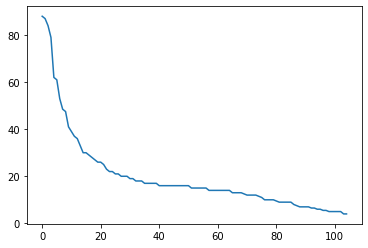

In [200]:
scores = rank_by_reliability(clusters_dict, intercluster_dists, contra_threshold=0.6)
sorted_clusters = sorted(scores, reverse=True)  # each element is (score, cluster_index)
scores_only = [score for score, _ in sorted_clusters]
import matplotlib.pyplot as plt
plt.plot(scores_only)

In [201]:
sorted_clusters[0]

(88.0, 77)

## Previous Single Summary Algo.

In [ ]:
from nltk.tokenize import RegexpTokenizer

def choose_longest(sentences):
    tokenizer = RegexpTokenizer(r'\w+')
    max_len = 0
    final_sent = None
    for sent in sentences:
        tokens = tokenizer.tokenize(sent)
        if len(tokens) > max_len:
            max_len = len(sent)
            final_sent = sent
    return final_sent

from lexrank import LexRank
from lexrank.mappings.stopwords import STOPWORDS
def choose_salient(sentences):
    """
    
    """
    lxr = LexRank(sentences, stopwords=STOPWORDS['en'])
    top_sentence = lxr.get_summary(sentences[0], summary_size=1, threshold=.1)
    return top_sentence[0]
    

def summarize(clusters, intersentence, sent_df, word_limit=90, coherence_threshold=0.6, redundancy_threshold=0.3):
    """
    :param clusters: dict of clusters of the form {str(cluster_num): list(sentence_indices)}.
    :param intersentence: Pandas DataFrame of precomputed inter-sentence distance in pairwise matrix form.
    :param sent_df: Pandas DataFrame of indexed sentences.
    :param word_limit: maximum num of words for summary.
    :param coherence_threshold: maximum distance allowed for a sentence pair within the summary. valid values between 0-1.
    :param redundancy_threshold: minimum distance allowed for a sentence pair within the summary. valid values between 0-1.
    
    We need a redundancy_threshold because the clustering algorithm does not always manage to group 
    redundant sentences together?
    """
    if coherence_threshold <= redundancy_threshold:
        raise Exception
    
    tokenizer = RegexpTokenizer(r'\w+') # tokenize into word-like tokens.
    summary = list()
    word_count = 0
    
    sorted_clusters = sorted(clusters.items(), key=lambda x: len(x[1]), reverse=True)  # iterable of pairs.
    
    for key, clust in sorted_clusters:
        sentences = [sent_df.iloc[idx]['sentence'] for idx in clust]
        #selected = choose_longest(clust)
        selected = choose_salient([sentences])
        selected_idx = sent_df[sent_df.sentence == selected].index[0]
        tokens = tokenizer.tokenize(selected)
        if word_count + len(tokens) < word_limit:
            max_dist = 0
            min_dist = 1
            for sent_idx in summary:
                dist = intersentence.iloc[sent_idx][selected_idx]
                if dist > max_dist:
                    max_dist = dist
                if dist < min_dist:
                    min_dist = dist
            if max_dist < coherence_threshold and min_dist > redundancy_threshold:
                summary.append(selected_idx)
                word_count = word_count + len(tokens)
        else:
            break
    return summary

In [ ]:
# test lexrank algorithm.
sentences = [sents_df.iloc[idx]['sentence'] for idx in clusters_dict['0']]
display(sentences)
choose_salient([sentences])

In [ ]:
# todo: think of statistical way to determine the coherence_threshold and redundancy_threshold.
summary = summarize(clusters_dict, intersentence, sents_df, word_limit=90, coherence_threshold=0.6, redundancy_threshold=0.35)
print("no. of sentences in summary: ", len(summary))
print("no. of sentences in source: ", len(intersentence.index.values))
print()
for sent_idx in summary:
    print(f"{sent_idx}: {sents_df.iloc[sent_idx]['sentence']}")
print()
for sent_idx in sorted(summary):
    print(f"{sent_idx}: {sents_df.iloc[sent_idx]['sentence']}")

## Multiple Summaries (deprecated)

In [ ]:
def multi_summary(clusters, intercluster_dists, sent_df, word_limit=100, contradiction_threshold=0.6):
    """
    :param clusters: dict of clusters of the form {str(cluster_index): list(sentence_indices)}.
    :param intercluster_dists: square numpy.ndarray representing distances between each cluster.
    :param sent_df: Pandas DataFrame of indexed sentences.
    :param word_limit: maximum num of words for summary.
    :param contradiction_threshold: float value between 0 and 1, representing the value after which
    sentence pairs will be considered contradictory.
    """
    # find top/representative sentence of each cluster.
    top_sentences = dict()
    for clust_idx, clust in clusters.items():
        sentences = [sent_df.iloc[idx]['sentence'] for idx in clust]
        selected = choose_salient([sentences])
        selected_idx = sent_df[sent_df.sentence == selected].index[0]
        top_sentences[int(clust_idx)] = selected_idx  # typecasted to int because json dicts saved integer keys into str keys.
    
    # find clusters that are not contradictory w ALL other clusters.
    base_clusters = list()
    contradicted_pairs = list()
    contradicted_set= set()
    for i in range(len(intercluster_dists)):
        for j in range(i+1,len(intercluster_dists)):
            if intercluster_dists[i][j] > contradiction_threshold:
                contradicted_pairs.append((i,j))
                contradicted_set.add(i)
                contradicted_set.add(j)
        if i not in contradicted_set:
            base_clusters.append(i)
    
    # construct base summary
    base_summary = list()
    word_count = 0
    tokenizer = RegexpTokenizer(r'\w+') # tokenize into word-like tokens.
    sorted_clusters = sorted(clusters.items(), key=lambda x: len(x[1]), reverse=True)  # iterable of pairs.
    for clust_idx, clust in sorted_clusters:
        if int(clust_idx) in base_clusters:
            selected_idx = top_sentences[int(clust_idx)]
            selected = sent_df.iloc[selected_idx]['sentence']
            tokens = tokenizer.tokenize(selected)
            if word_count + len(tokens) < word_limit:
                base_summary.append(selected_idx)
                word_count = word_count + len(tokens)
            else:
                break
    
    # construct summaries w contentious information.
    all_summaries = list()
    added_sentences = set()
    for clust1, clust2 in contradicted_pairs:
        sent1 =  top_sentences[clust1]
        sent2 =  top_sentences[clust2]
        
        if sent1 not in added_sentences:
            all_summaries.append(base_summary + [sent1])
            added_sentences.add(sent1)
        if sent2 not in added_sentences:
            all_summaries.append(base_summary + [sent2])
            added_sentences.add(sent2)
    print(base_summary)
    return all_summaries, base_summary

In [ ]:
from IPython.display import Markdown
all_summaries, base_summary = multi_summary(clusters_dict, intercluster_dists, sents_df, word_limit=90, contradiction_threshold=0.6)

print(f"total no. of summaries = {len(all_summaries)}")
print()

for summary in all_summaries:
    print("no. of sentences in summary: ", len(summary))
    print("no. of sentences in source: ", len(intersentence.index.values))
    print()
    for sent_idx in sorted(summary):
        if sent_idx in base_summary:
            display(Markdown(f"**{sent_idx}: {sents_df.iloc[sent_idx]['sentence']}**"))
        else:
            display(Markdown(f"{sent_idx}: {sents_df.iloc[sent_idx]['sentence']}"))
    print()